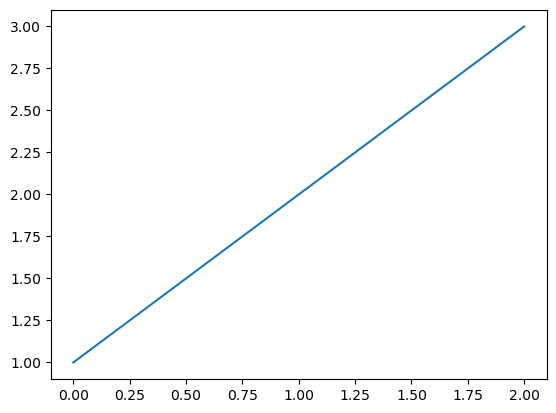

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from torch.distributions import MultivariateNormal
from torch.distributions.kl import kl_divergence
from torch.optim import Adam
from torchvision.datasets import MNIST,FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid


In [3]:
transform = transforms.Compose(
    [transforms.Pad(padding=2), transforms.ToTensor()]
)

path = './data'

train_dataset = FashionMNIST(
    path, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(
    path, train=False, download=True, transform=transform)

batch_size=100
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [4]:
image = next(iter(train_loader))

In [5]:
image[0].shape

torch.Size([100, 1, 32, 32])

In [6]:
x = image[0].reshape(-1,32*32)

In [7]:
x.shape

torch.Size([100, 1024])

In [8]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

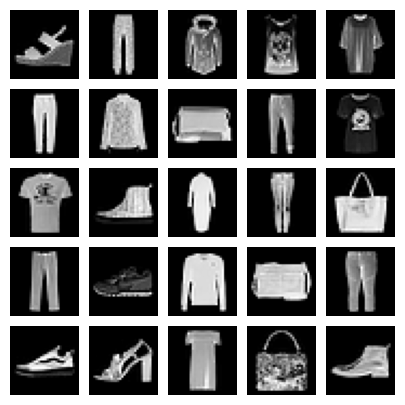

In [9]:
num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig,111,nrows_ncols=(5,5), axes_pad=0.1)

for ax, im in zip(grid,sample_images):
    ax.imshow(im,cmap='gray')
    ax.axis('off')

In [10]:
class Encoder(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,latent_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,latent_dim)
        
        self.mean_layer = nn.Linear(latent_dim,2)
        self.logvar_layer = nn.Linear(latent_dim,2)
        
    def forward(self,x):
        
        x = self.fc1(x)
        x = F.leaky_relu(x,0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x,0.2)
        
        mean = self.mean_layer(x)

        logvar = self.logvar_layer(x)
        
        return mean, logvar
        

In [11]:
class Decoder(nn.Module):
    
    def __init__(self,latent_dim,hidden_dim,input_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(2,latent_dim)
        self.fc2 = nn.Linear(latent_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,input_dim)
        
    def forward(self,u):
        
        u = self.fc1(u)
        u = F.leaky_relu(u,0.2)
        u = self.fc2(u)
        u = F.leaky_relu(u,0.2)
        u = self.fc3(u)
        
        z = F.sigmoid(u).to(torch.float)
        
        return z
        

In [12]:
class VAE(nn.Module):
    
    def __init__(self,input_dim=1024,hidden_dim=400,latent_dim=200):
        super().__init__()
        
        self.encoder = Encoder(input_dim,hidden_dim,latent_dim)
        self.decoder = Decoder(latent_dim,hidden_dim,input_dim)
        
    def reparametrize(self,mean,var):
        epsilon = torch.randn_like(var)

        z = mean + torch.sqrt(var) * epsilon
        return z
    
    def forward(self,x):
        
        mean, logvar = self.encoder(x)
        
        u = self.reparametrize(mean,torch.exp(logvar))

        z = self.decoder(u)
        
        return z, mean, logvar
        
        
        

In [13]:
vae = VAE()

In [14]:
z,mean,logvar = vae(x)

In [15]:
def loss_function(x,z,mean,logvar):
    reconstruction_loss = F.binary_cross_entropy(z,x,reduction='sum')
    KL_div =  - 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss - KL_div

In [16]:
F.binary_cross_entropy(z,x,reduction='sum')

tensor(71242.4453, grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
- 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))

tensor(0.1543, grad_fn=<MulBackward0>)

In [18]:
optimizer = Adam(vae.parameters(),lr=1e-3)

In [20]:
epochs = 50
for e in range(epochs):
    overall_loss = 0.0
    for i,img in enumerate(train_loader):
        
        x = img[0].reshape(-1,32*32)

        z,mean,logvar = vae(x)

        if torch.isnan(z).any():
            print("NaN values found in z. Skipping this batch.")
            continue
        
        optimizer.zero_grad()

        # print(x)
        # print(z)

        # x = torch.sigmoid(x)  #
        # z = torch.sigmoid(z)  #

        loss = loss_function(x,z,mean,logvar)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", e + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))

        
  

NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping this batch.
NaN values found in z. Skipping 

In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)
    x_decoded = vae.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(32, 32) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

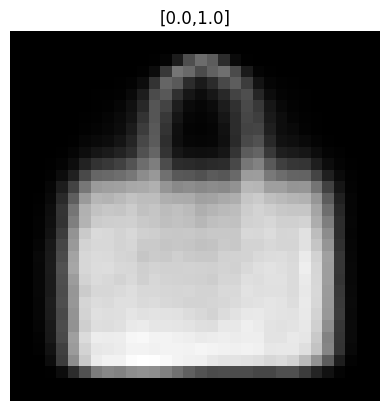

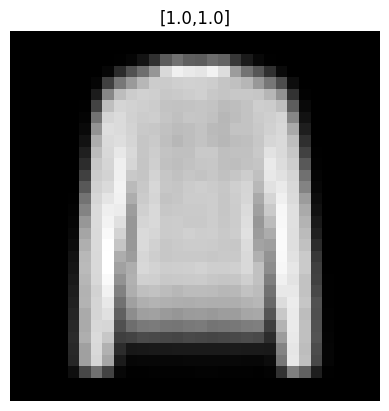

(None, None)

In [ ]:
generate_digit(0.0,1.0),generate_digit(1.0,1.0)

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=32, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

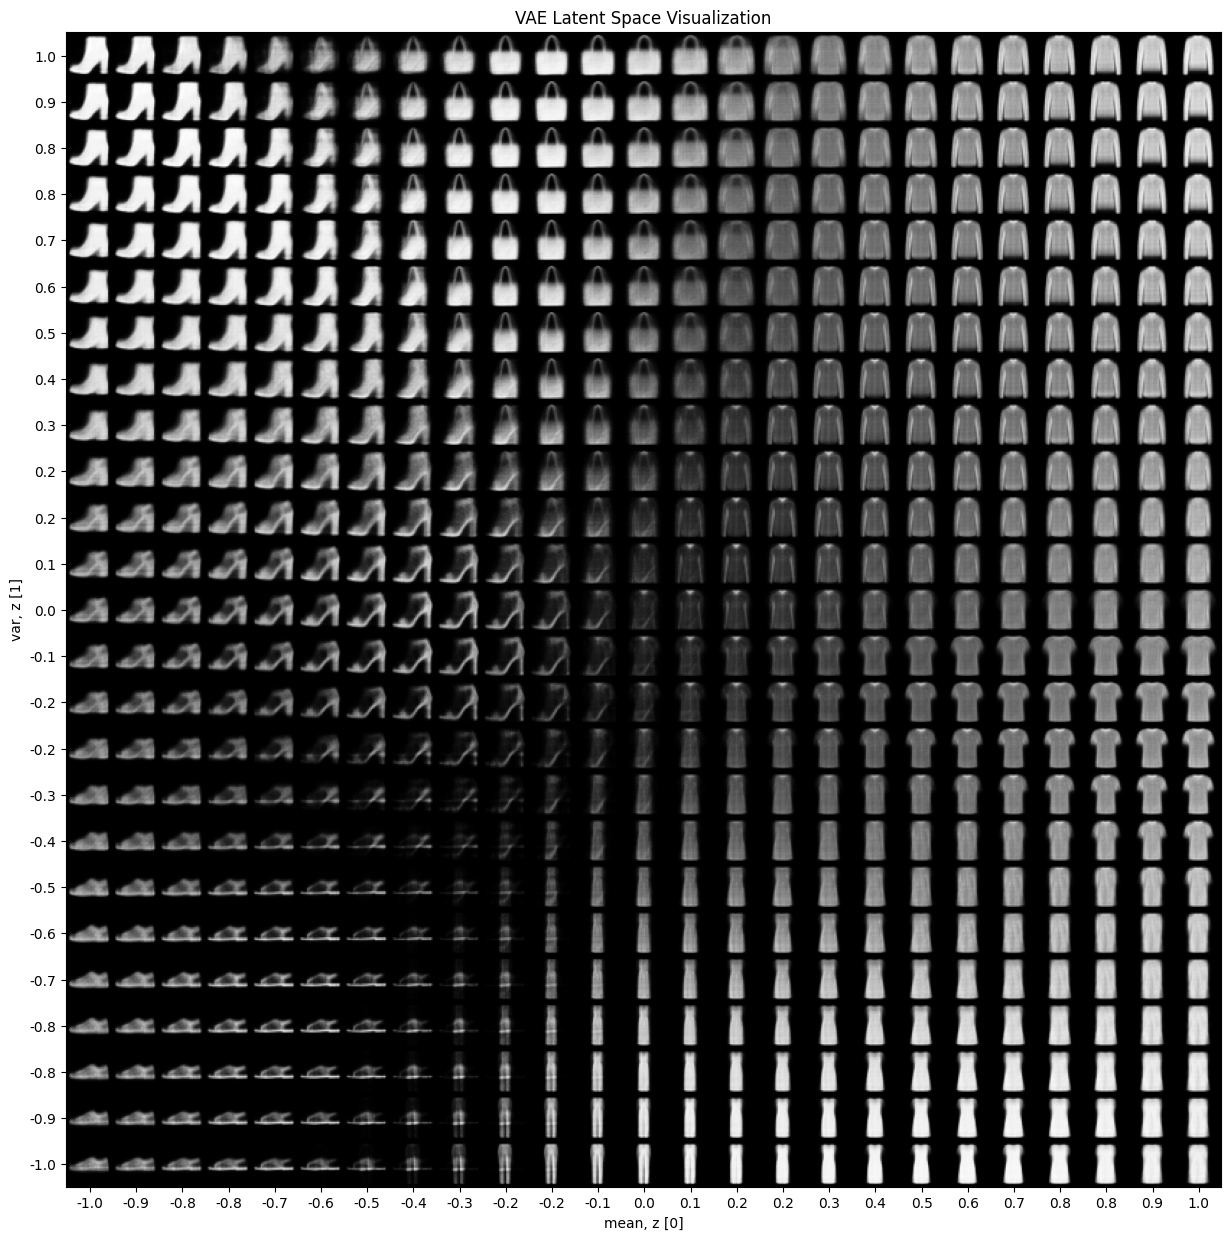

In [ ]:
plot_latent_space(vae, scale=1.0)

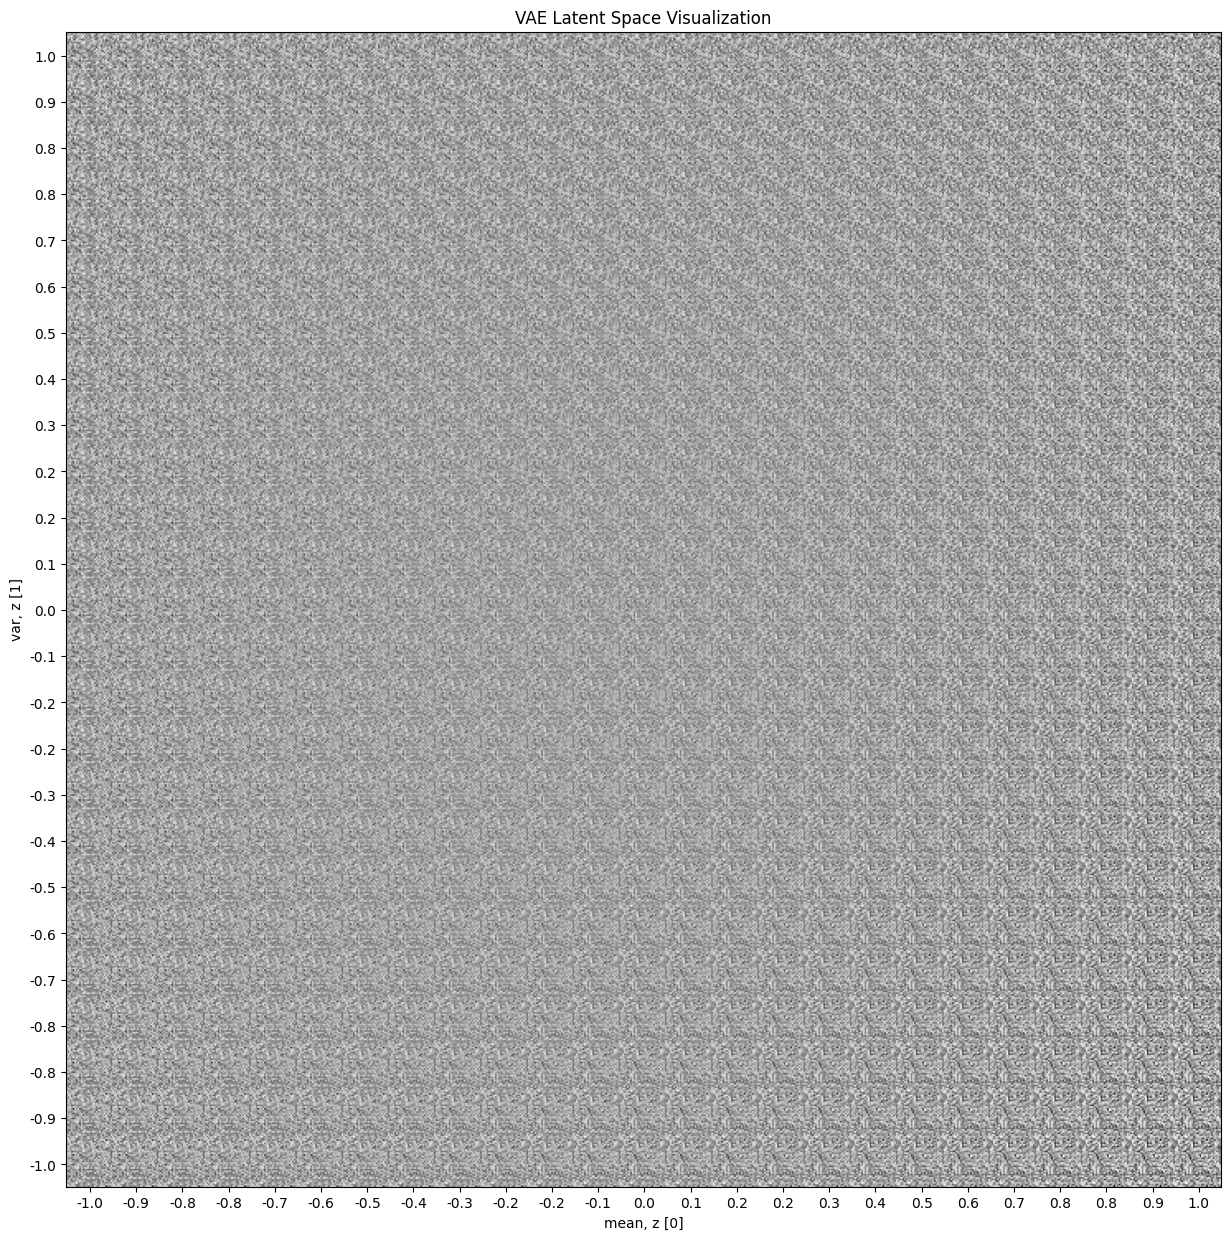

In [ ]:
plot_latent_space(vae, scale=1.0)

In [ ]:
epsilon = torch.randn(20,2)

In [ ]:
x = next(iter(test_loader))

In [ ]:
x = x[0][10]

In [ ]:
x = x.reshape(28,28)

In [ ]:
plt.imshow(x)

In [ ]:
x = x.reshape(1,1,28*28)

In [ ]:
x_hat,mean,logvar = vae(x)

In [ ]:
latent_samples = mean + epsilon*torch.exp(logvar)

In [ ]:
latent_samples

In [ ]:
imgs = vae.decoder(latent_samples).detach()

In [ ]:
imgs = imgs.reshape(20,28,28)

In [ ]:
imgs[0].shape

In [ ]:
plt.imshow(imgs[11])